In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import pprint
import pickle
import json
import os, sys
os.chdir("../")
from util import *

In [2]:
def plot_line(value, label, color, ax, fontsize):
    ax.text(5, value, label, {"fontsize": fontsize})
    ax.axhline(y=value, color=color, linestyle="-")

def all_solved_instances(dfs):
    instances = []
    for n in range(1, 16):
        for k in range(1, 16):
            good = True
            for df, cant in dfs:
                if ((df["n"] == n) & (df["k"] == k)).sum() < cant:
                    good = False
                    break
            if good:
                instances.append((n, k))
    return instances

def add_rounded_idx(df, base):
    df["rounded idx"] = df["idx"].apply(lambda idx : idx // base * base if idx < 100 else 100 - base)
    df = df.loc[df["idx"] <= (df["rounded idx"].max()-1)*base]
    return df

def add_convolution(df, window_size):
    df["mean transitions"] = list(np.convolve(list(df["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+\
                                [np.nan for _ in range(window_size-1)]
    df["mean transitions / total"] = df["mean transitions"] / df["total transitions"]
    return df

def fillna(df):
    df["expanded transitions"] = df["expanded transitions"].fillna(df["expanded transitions"].max()+10)
    return df

In [6]:
problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
old_files = ["base_features_2h", "ra_feature2opt_2h", "5mill_RA", "5mill_L"]

files = [(f, "focused") for f in ["focused_1", "focused_2", "focused_4", "focused_5", "focused_6", "focused_7", "5mill_JE_NORA"]]
files += [("focused_R", "focused_R")]
files += [("3stepQ", "3stepQ")]
files += [("10stepQ", "10stepQ")]
files += [(f, "multiple") for f in ["5mill_RR10k_NORA", "multiple_1", "multiple_2"]]


In [4]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

In [7]:
df_all = {}
df_ra_5s = {}
df_random_5s = {}
df_ra_10m = {}
df_random_10m = {}

for problem in problems:
    df_all[problem] = {}
    for file, group in files:
        if file in old_files:
            path = results_path(problem)+"/"+file+"/"+filename([problem, n, k])+".csv"
        else:
            path = results_path(problem)+"/"+file+"/generalization_all.csv"
        try:
            df = pd.read_csv(path)
        except:
            print("File not found", path)
            continue
        df = df.dropna(subset=["expanded transitions"])
        df["instance"] = df.apply((lambda r: (r["problem"], r["n"], r["k"])), axis=1)
        df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
        df["group"] = group
        df["training steps"] = df["idx"]*50000
        df["expanded transitions / total"] = df["expanded transitions"] / df["total transitions"]
        df_all[problem][file] = df

    df_ra_5s[problem] = pd.read_csv(results_path(problem)+"/RA_5s_15.csv")
    df_random_5s[problem] = pd.read_csv(results_path(problem)+"/random_5s.csv")

    df_ra_10m[problem] = pd.read_csv(results_path(problem)+"/all_ra_afterfix_15.csv")
    df_random_10m[problem] = pd.read_csv(results_path(problem)+"/all_random.csv")

    for df in [x[problem] for x in [df_ra_5s, df_random_5s, df_ra_10m, df_random_10m]]:
        df["instance"] = df.apply(lambda r: (r["problem"], r["n"], r["k"]), axis=1)
        df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
        df.dropna(subset=["expanded transitions"])

File not found experiments/results/AT_2_2//10stepQ/generalization_all.csv
File not found experiments/results/BW_2_2//10stepQ/generalization_all.csv
File not found experiments/results/CM_2_2//5mill_RR10k_NORA/generalization_all.csv
File not found experiments/results/CM_2_2//multiple_1/generalization_all.csv
File not found experiments/results/CM_2_2//multiple_2/generalization_all.csv
File not found experiments/results/DP_2_2//10stepQ/generalization_all.csv
File not found experiments/results/TA_2_2//10stepQ/generalization_all.csv
File not found experiments/results/TL_2_2//10stepQ/generalization_all.csv
File not found experiments/results/TL_2_2//5mill_RR10k_NORA/generalization_all.csv
File not found experiments/results/TL_2_2//multiple_1/generalization_all.csv
File not found experiments/results/TL_2_2//multiple_2/generalization_all.csv


## Comparing test transitions

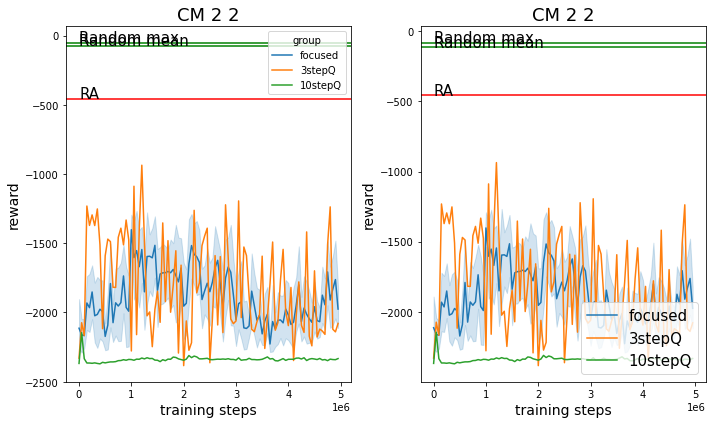

In [10]:
n, k = 2, 2

used_problems = ["CM", "CM"]#[p for p in problems if p != "CM"] if n == 3 else problems
used_files = [(f, g) for f, g in files if g in ["focused", "3stepQ", "10stepQ"]]

f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))

for i in range(len(used_problems)):
    problem = used_problems[i]

    df = pd.concat([df_all[problem][file] for file, group in used_files], ignore_index=True)
    df = df.loc[(df["n"]==n)&(df["k"]==k)]
    df["reward"] = -df["expanded transitions"]

    sns.lineplot(data=df, x="training steps", y="reward", ax=axs[i], hue="group")
    
    ra = ra_results["expanded transitions", problem][n][k]
    plot_line(-ra, "RA", "red", axs[i], 15)
    
    random_min = min(random_results_small[(problems[i], n, k)])
    random_mean = np.mean(random_results_small[(problems[i], n, k)])
    
    plot_line(-random_min, "Random max", "green", axs[i], 15)
    plot_line(-random_mean, "Random mean", "green", axs[i], 15)
    
    axs[i].set_title(" ".join([problem, str(n), str(k)]), fontdict={"fontsize": 18})

handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg")
plt.show()

## Plotting training performance

In [ ]:
import jpype
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=['mtsa.jar'])
#from MTSTools.ac.ic.doc.mtstools.model.operations.DCS.nonblocking import DCSForPython

In [ ]:
def read_training_data(problem, file, multiple):
    with open(results_path(problem, file=file)+"/training_data.pkl", "rb") as f:
        training_data, agent_params, env_params = pickle.load(f)    
    df = pd.DataFrame(training_data)
    df["idx"] = df["training steps"] // 10000
    df["file"] = file
    df["problem"] = problem
    df["multiple"] = multiple
    if multiple:
        instances = train_instances(problem)
        df["n"] = df.apply(lambda r: instances[int(r["idx"]) % len(instances)][1], axis=1)
        df["k"] = df.apply(lambda r: instances[int(r["idx"]) % len(instances)][2], axis=1)
    else:
        df["n"] = 2
        df["k"] = 2
    return df

df_train = {}
max_steps = 5000000

used_files = [(f, g) for f, g in files if f in ["3stepQ", "focused_1"]]
used_problems = problems

for problem in used_problems:
    df_train[problem] = {}
    for file, group in used_files:
        multiple = "RR" in group
        df = read_training_data(problem, file, multiple)
        df = df.loc[df["training steps"] <= max_steps]
        df["group"] = group
        df_train[problem][file] = df

In [ ]:
normalized = False
for problem in used_problems:
    for file, group in used_files:
        df = df_train[problem][file]
        df["total transitions"] = df.apply(lambda r: monolithic_results["expanded transitions", r["problem"]][r["k"]][r["n"]], axis=1)
        window_size = 100
        
        if normalized:
            df['norm transitions'] = df.groupby('total transitions')["expanded transitions"].apply(lambda x: (x - x.mean()) / x.std())
            df["mean transitions"] = list(np.convolve(list(df["norm transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        else:
            df["mean transitions"] = list(np.convolve(list(df["expanded transitions"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
        base = 10000
        df["training steps"] = df["training steps"] // base * base

In [ ]:
def plot_ra_and_random(files, problem, n, k, ax):
    ra = ra_results["expanded transitions", problem][n][k]
    random_min = min(random_results_small[(problem, n, k)])
    random_mean = np.mean(random_results_small[(problem, n, k)])
    plot_line(-ra, "RA", "red", ax, 15)
    plot_line(-random_min, "Random max", "green", ax, 15)
    plot_line(-random_mean, "Random mean", "green", ax, 15)

In [ ]:
f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))

for i in range(len(used_problems)):
    problem = used_problems[i]
    df = pd.concat([df_train[problem][f] for f, group in used_files], ignore_index=True)
    df["reward"] = -df["mean transitions"]
    
    print("Plotting", problem)
    sns.lineplot(data=df, x="training steps", y="reward", ax=axs[i], hue="group", ci="sd", alpha=0.6)
    
    plot_ra_and_random(files, problems[i], 2, 2, axs[i])
    
    axs[i].get_legend().remove()
    #if i != 0:
    #    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(problems[i], fontdict={"fontsize": 18})

handles, labels = axs[0].get_legend_handles_labels()
plt.legend(handles, labels, prop={'size': 15}, loc="lower right")
plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg")

## Plot solved

In [ ]:
def get_df_solved(problem, file, group):
    df = df_all[problem][file]
        
    df_solved = []
    for x, cant in dict(df["idx"].value_counts()).items():
        df_solved.append({"idx": x, "solved": cant})
    df_solved = pd.DataFrame(df_solved)
    df_solved.sort_values(by="idx", inplace=True)

    df_solved["file"] = file
    df_solved["group"] = group
    
    window_size = 10
    df_solved["max solved"] = df_solved["solved"].cummax()
    df_solved["mean solved"] = list(np.convolve(list(df_solved["solved"]), np.ones(window_size), mode='valid')/window_size)+\
                                [np.nan for _ in range(window_size-1)]
    return df_solved

used_problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
used_files = [(f, g) for f, g in files if g in ["3stepQ", "focused"]]

df_solved = {p: pd.concat([get_df_solved(p, f, g) for f, g in used_files], ignore_index=True) for p in used_problems}
solved_ra = {p: len(list(df_ra_5s[p]["expanded transitions"].dropna())) for p in used_problems}
solved_random = {p: len(list(df_random_5s[p]["expanded transitions"].dropna())) / 20 for p in used_problems}

In [ ]:
best_idx = {}

used_files = [(f, g) for f, g in files if g in ["focused"]]
print(used_files)
for p in problems:
    best_idx[p] = []
    for file, group in used_files:
        best_idx[p].append(best_generalization_agent(p, file))
    print(p, best_idx[p])

In [ ]:
f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))

for i in range(len(used_problems)):
    problem = used_problems[i]
    
    plot_line(solved_ra[problem], "RA", "red", axs[i], 15)
    plot_line(solved_random[problem], "Random", "green", axs[i], 15)
    
    # sns.lineplot(data=df_solved[problem], x="idx", y="solved", ax=axs[i], estimator=None, units="file", hue="group")
    sns.lineplot(data=df_solved[problem], x="idx", y="solved", ax=axs[i], hue="group")

    axs[i].set_title(problem)

plt.tight_layout()

plt.savefig("experiments/figures/tmp.jpg", dpi=500)
plt.show()

## Plot mean transitions generalization

In [ ]:
def get_mean_reward_df(problem, file, group, instances):
    df = df_all[problem][file]
    dfl = df.loc[df["instance"].isin(instances)]

    df = pd.DataFrame([{"idx": cidx, "reward": -dfg["expanded transitions"].sum()} for cidx, dfg in dfl.groupby("idx")])
    df.sort_values(by="idx", inplace=True)
    df["file"] = file
    df["group"] = group

    window_size = 10
    df["min reward"] = df["reward"].cummax()
    df["mean reward"] = list(np.convolve(list(df["reward"]), np.ones(window_size), mode='valid')/window_size)+[np.nan for _ in range(window_size-1)]
    return df

used_problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
used_files = [(f, g) for f, g in files if g == "focused"]

instances, df_ra, df_random, df_agent = {}, {}, {}, {}
for p in used_problems:
    instances[p] = all_solved_instances([(df_all[p][f], 100) for f,g in used_files]+\
                                        [(df_ra_10m[p], 1)])
                                        #[(df_random_10m[p], 1)])
    instances[p] = [(p, n, k) for n, k in instances[p]]
    df_ra[p] = df_ra_10m[p].loc[df_ra_10m[p]["instance"].isin(instances[p])]
    # df_random[p] = df_random_10m[p].loc[df_random_10m[p]["instance"].isin(instances[p])]  
    df_agent[p] = pd.concat([get_mean_reward_df(p, f, g, instances[p]) for f, g in used_files], ignore_index=True)

In [ ]:
for problem in used_problems:
    print(problem)
    print([(n, k) for p, n, k in instances[problem]])

In [ ]:
f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))
for i in range(len(used_problems)):
    problem = used_problems[i]
    
    plot_line(-df_ra[problem]["expanded transitions"].dropna().sum(), "RA", "red", axs[i], 15)
    plot_line(-df_random[problem]["expanded transitions"].dropna().sum(), "Random mean", "green", axs[i], 15)
    
    sns.lineplot(data=df_agent[problem], x="idx", y="reward", ax=axs[i], ci="sd", hue="group")
    axs[i].set_title(problem)

plt.tight_layout()

plt.savefig("experiments/figures/tmp.jpg", dpi=500)
plt.show()

## 15 15 Solved

In [ ]:
grey = "#d0e1d4"
red = "#ed6a5a"
blue = "#008bf8"
green = "#08a045"
green1 = "#adc178"
green2 = "#045c27"

In [ ]:
def get_comp_solved_df(agent, ra):
    only_ra = ((agent == float("inf")) & (ra != float("inf")))
    only_agent = ((agent != float("inf")) & (ra == float("inf")))
    both = ((agent != float("inf")) & (ra != float("inf")))
    
    return only_ra*1 + only_agent*2 + both*(3*(agent > ra) + 4*(agent == ra) + 5*(agent < ra))

df1 = lambda problem: get_df_agent(problem, "3stepQ/all.csv")
df2 = lambda problem: get_df_agent(problem, "focused_R/all.csv")
# df2 = lambda problem: get_df_comp(problem, ra_results)

used_problems = problems

f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))
for i in range(len(used_problems)):
    problem = used_problems[i]
    df1p = df1(problem)
    df2p = df2(problem)
    sns.heatmap(data=get_comp_solved_df(df1(problem), df2(problem)), cmap=[grey, red, blue, green, green1, green2], vmin=0, vmax=5, ax=axs[i], cbar=False)
    
    for problem, n, k in train_instances(problem):
        axs[i].text(k - 0.5, n - 0.5, "X",
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
    
    axs[i].invert_yaxis()
    axs[i].set_title(problem, fontsize=30)

plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg", dpi=200)
plt.show()

## 15 15 transitions

In [ ]:
vmin = -3
vmax = 3

def best_transitions_agent(df_all):
    instances = all_solved_instances([df_all])
    
    df_all["instance"] = df_all.apply(lambda r: (r["n"], r["k"]), axis=1)
    df_all = df_all.loc[df_all["instance"].isin(instances)]
    return min([(dfg["expanded transitions"].sum(), cidx) for cidx, dfg in df_all.groupby("idx")])[1]

def df_agent_5s(problem, file):
    df_all = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
    df_all["file"] = file
    df_all = df_all.dropna(subset=["expanded transitions"])
    idx = best_transitions_agent(df_all)
    print(problem)
    print(idx)
    print(best_generalization_agent(problem, file))
    df_agent = df_all.loc[df_all["idx"] == idx]
    df_agent = fill_df(df_agent, 15)
    return df_agent.pivot("n", "k", "expanded transitions")

def get_solved_value(a, r):
    # Possibilities:
    # 0. not solved
    # 1. not solved by the agent and solved by RA
    # 2. solved sometimes by the agent and not solved by RA
    # 3. solved sometimes by the agent and solved by RA
    # 4. solved always by the agent and not solved by RA
    # 5. solved always by the agent and solved by RA
    solved_ra = r != float("inf")
    solved_agent = [ai != float("inf") for ai in a]
    if not np.any(solved_agent):
        return 0 if not solved_ra else 1
    elif np.all(solved_agent):
        return 4 if not solved_ra else 5
    else:
        return 2 if not solved_ra else 3

def get_trans_rel_solved(a, r):
    if r == float("inf") or np.any([ai == float("inf") for ai in a]):
        return np.nan
    else:
        return np.mean([np.log2(ai / r) for ai in a])
    
def get_df(agent_dfs, ra, func):
    m = np.zeros(shape=(15, 15))
    for n in range(15):
        for k in range(15):
            r = ra[k+1][n+1]
            a = [df[k+1][n+1] for df in agent_dfs]
            m[n, k] = func(a, r)
    return m

agent_files = ["5mill_JE_NORA", "focused_1", "focused_2", "focused_4",
               "focused_5", "focused_6", "focused_7"]
# agent_files = ["3stepQ"]

used_problems = problems


trans_df = {}
solved_df = {}
for i in range(len(used_problems)):
    problem = used_problems[i]
    dfs_agent = [get_df_agent(problem, file+"/all.csv") for file in agent_files]
    #dfs_agent = [df_agent_5s(problems[i], file) for file in agent_files]
    #df_ra = get_df_agent(problem, "focused_R/all.csv")
    df_ra = get_df_comp(problem, ra_results)
    trans_df[problem] = get_df(dfs_agent, df_ra, get_trans_rel_solved)
    solved_df[problem] = get_df(dfs_agent, df_ra, get_solved_value)


In [ ]:
grey = "#d0e1d4"
red = "#ed6a5a"
blue = "#008bf8"
green = "#08a045"
green1 = "#adc178"
green2 = "#045c27"
white = "#ffffff"
yellow = "#ffff00"

# 0. not solved
# 1. not solved by the agent and solved by RA
# 2. solved sometimes by the agent and not solved by RA
# 3. solved sometimes by the agent and solved by RA
# 4. solved always by the agent and not solved by RA
# 5. solved always by the agent and solved by RA


f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))
for i in range(len(used_problems)):
    p = used_problems[i]

    # annot_df = pd.DataFrame(solved_df[p])
    # cmap = "coolwarm"
    cmap = [white, red, green2, yellow, green, grey]
    
    sns.heatmap(data=solved_df[p], 
                cmap=cmap, 
                annot=False, annot_kws={"size":6},
                ax=axs[i], cbar=True, vmin=0, vmax=5)
    
    axs[i].invert_yaxis()
    axs[i].set_title(p, fontsize=30)

plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg", dpi=200)
plt.show()

## Solved table

In [ ]:
def solved_metric(df, factor=1):
    return len(df["expanded transitions"].dropna()) / factor

instances = {}
for p in problems:
    agent_files = [(df_all[p][f], 100) for f, g in files if f in df_all[p].keys()]
    instances[p] = all_solved_instances(agent_files+\
                                        [(df_ra_5s[p], 1)]+\
                                        [(df_random_5s[p], 20)])
    instances[p] = [(p, n, k) for n, k in instances[p]]

def mean_trans_metric(df, factor=1):
    dfl = df.loc[df["instance"].isin(instances[df["problem"].iloc[0]])]
    return (dfl["expanded transitions"] / dfl["total transitions"]).mean()

used_files = files

timeout = "10m"
metric = solved_metric

groups = list({g for f, g in used_files}.union({"random", "ra"}))
results = {p: {ap: [] for ap in groups} for p in problems+["all", "all (AT, BW, DP, TA)"]}

for i in range(len(problems)):
    for file, group in files:
        if group == "multiple" and (problems[i] not in ["AT", "TA", "BW", "DP"]):
            continue
        if timeout == "5s":
            df = df_all[problems[i]][file]
            best_idx = best_generalization_agent(problems[i], file)
            df = df.loc[df["idx"] == best_idx]
        else:
            df = pd.read_csv("experiments/results/"+filename([problems[i], 2, 2])+"/"+file+"/all.csv")
        results[problems[i]][group].append(metric(df))
    
    if timeout == "10m":
        results[problems[i]]["random"].append(metric(df_random_10m[problems[i]]))
        results[problems[i]]["ra"].append(metric(df_ra_10m[problems[i]]))
    else:
        results[problems[i]]["random"].append(metric(df_random_5s[problems[i]], factor=20))
        results[problems[i]]["ra"].append(metric(df_ra_5s[problems[i]]))

In [ ]:
for group in groups:
    n = len(results["AT"][group])
    if group != "multiple":
        results["all"][group] = [0 for j in range(n)]
        for j in range(n):
            for problem in problems:
                results["all"][group][j] += results[problem][group][j]
    
    results["all (AT, BW, DP, TA)"][group] = [0 for j in range(n)]
    for j in range(n):
        for problem in ["AT", "BW", "DP", "TA"]:
            results["all (AT, BW, DP, TA)"][group][j] += results[problem][group][j]

In [ ]:
from scipy.stats import ttest_1samp, wilcoxon

for problem in problems+["all"]:
    print(problem)
    random = results[problem]["random"][0]
    ra = results[problem]["ra"][0] / random
    agent = np.array(results[problem]["focused"]) / random
    print(np.round(np.mean(agent), 2), np.round(ra, 2), ttest_1samp(agent-ra, 0, alternative="two-sided").pvalue)
    
# p-valores con ttest:
# AT significativamente mejor.
# BW significativamente mejor.
# CM significativemente peor.
# DP significativemente peor.
# TA iguales.
# TL iguales.
# General: iguales! (por muy poquito jaja, p=0.059)
# Faltaría chequear la validez de este test.

In [ ]:
rows = [{"approach": ap} for ap in groups]
for problem in problems+["all", "all (AT, BW, DP, TA)"]:
    for j in range(len(groups)):
        r = results[problem][groups[j]]
        #print(problem, groups[j], r)
        if len(r) == 0:
            continue
        #r = np.array(r) / results[problem]["random"][0]
        mean = np.round(np.mean(r), 2)
        std = np.round(np.std(r), 2)
        if std > 0.0001:
            rows[j][problem] = str(mean) + " ± " + str(std)
        else:
            rows[j][problem] = str(mean)

dft = pd.DataFrame(rows)

#print(dft.to_latex(index=False, float_format="%.2f"))
print(dft)

## Solved instances vs expanded transitions

In [ ]:
n, k = 2, 2
for problem in ["AT", "BW", "CM", "DP", "TA", "TL"]:
    print(problem)
    file = "focused_1"

    df_all = pd.read_csv("experiments/results/"+filename([problem, 2, 2])+"/"+file+"/generalization_all.csv")
    df = []
    for x, cant in dict(df_all["idx"].value_counts()).items():
        df.append({"idx": x, "solved": cant})
    df = pd.DataFrame(df)
    df.sort_values(by="idx", inplace=True)

    solved = list(df["solved"])
    trans = list(-df_all.loc[(df_all["n"] == n) & (df_all["k"] == k)]["expanded transitions"])

    sns.regplot(x=trans, y=solved)
    plt.show()

## Exploration efficiency

In [ ]:
used_problems = problems
used_files = [(f, g) for f, g in files if g == "focused"]

f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))
for i in range(len(used_problems)):
    p = used_problems[i]
    df_agents = [pd.read_csv("experiments/results/"+filename([p, 2, 2])+"/"+f+"/"+"all.csv") for f, g in used_files]
    df_ra = pd.read_csv("experiments/results/"+filename([p, 2, 2])+"/all_ra_afterfix_15.csv")
    df_agents = pd.concat(df_agents, ignore_index=True)
    df_agents["group"] = "focused"
    df_ra["group"] = "RA"
    df = pd.concat([df_agents, df_ra], ignore_index=True)
    df = df.dropna(subset=["expanded transitions"])
    df["transition cost"] = df["expanded transitions"] / df["synthesis time(ms)"]

    sns.histplot(data=df, x="transition cost", hue="group", ax=axs[i])
    axs[i].set_title(p, fontsize=30)

plt.tight_layout()
plt.savefig("experiments/figures/tmp.jpg", dpi=200)
plt.show()